# Age Estimation and Gender Classification

In this assignment, you will train CNN models to estimate a person's age and gender by given a face image. Please read carefully all the instructions before you start to write your code.

**Your tasks**

You need train two CNN models:
- one is defined by you with a few restrictions and be trained from scratch, save it as `age_gender_A.h5`
- the other is to finetune a pretrained model, save it as `age_gender_B.h5`

**Dataset**

Your models will be trained and validated on a folder `train_val/` containing 5,000 labeled face images (size: 128 x 128), originated from the UTKFace dataset. During marking, your code will be tested on unseen test data. 

**Performance metric**

The metrics for measuring the performance on the test set are:
- age estimation: MAE (Mean Absolute Error)
- gender classification: accuracy

**Please use the GPU time wisely.**

Just be aware that there is some limit of free GPU usage (It is said the users can use up to 12 hours in row. But many people found they reached its limit far less than 12 hours.). Therefore, I would give you three suggestions to mimimise the risk of reaching the limit.

1. Make sure you have a stable internet connection.
2. Double check all the hyperparameters are good before you start to train the model.
3. According to my experience, each model should be trained in less than 2 hours. If much longer than that, you'd better consider adjusting the architecture.

## Setting Up: Mount the google drive
Mount your google drive to the notebook. 

Also don't forget to **enable GPU** before your training.


In [ ]:
# Download and extract the image dataset

!rm -r data
!gdown --id 13MRa51YRElF8n88Kh7RMglJCqSrTmrcg

import zipfile
with zipfile.ZipFile(f'./data.zip', 'r') as zip:
    zip.extractall('.')
!rm data.zip

In [1]:
import glob
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.client import device_lib

In [2]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2139561562578087812
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
locality {
  bus_id: 1
}
incarnation: 2930308991193655655
physical_device_desc: "device: 0, name: METAL, pci bus id: <undefined>"
xla_global_id: -1
]Metal device set to: Apple M1 Pro



2022-03-21 18:55:07.646883: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-21 18:55:07.647295: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
# Establishing constants

MODEL_FOLDER = './' # Where the model will be saved

DATA_DIRECTORY = './data'
BATCH_SIZE=128
LEARNING_RATE=0.0025
EPOCHS=150
COLOR_MODE='rgb' # Can be 'rgb' or 'grayscale', amongst other optionse
IMAGE_SIZE=(128, 128) # Width x height, can be larger than input image 
INPUT_SHAPE=IMAGE_SIZE + (1 if COLOR_MODE == "grayscale" else 3,) # Width x height x colour profile (RGB = 3 channels, grayscale = 1 channel)

# RANDOM_CROP_WIDTH = 96
# RANDOM_CROP_HEIGHT = 96

ROTATION_RANGE = 15
HORIZONTAL_FLIP = True
WIDTH_SHIFT_RANGE=0
HEIGHT_SHIFT_RANGE=0

# assert RANDOM_CROP_WIDTH <= IMAGE_SIZE[0]
# assert RANDOM_CROP_HEIGHT <= IMAGE_SIZE[1]

In [4]:
files = glob.glob(DATA_DIRECTORY + '/**/*.jpg')
files = sorted(files)

data_df = pd.read_csv(f'{DATA_DIRECTORY}/metadata_lookup.csv')

print(f"Total number of files: {len(files)}")

Total number of files: 5000


## Visualize a few photos
It is always benificial to know your data well before you start. Here display a few (at least 20) images together with its corresponding age and gender from the `train_val/` folder to have a first impression of the dataset. You may also check what the size of the images are.

In [5]:
%matplotlib inline

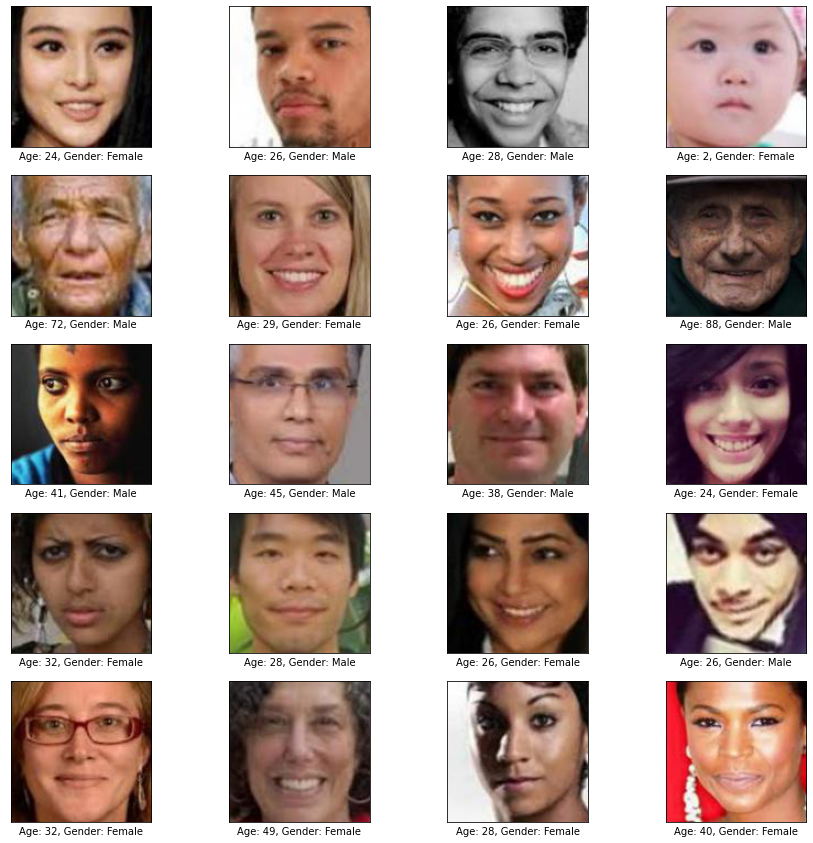

In [6]:
# Display a random 20 images from the dataset with the corresponding labels
import random
ids = random.sample(range(0, 5000), 20)

plt.figure(figsize=(15, 15))

for i, id in enumerate(ids, 1):
  img = Image.open(files[id])
  
  age = data_df.loc[id]['age']
  gender = data_df.loc[id]['gender']

  plt.subplot(5,4,i)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img)
  
  label = "Age: {age}, Gender: {gender}".format(age=age, gender="Male" if gender==0 else "Female")
  plt.xlabel(label)

plt.show()

## Rearrange the dataset
You may do any arrangement for the dataset to suit your later process, such as splitting into training set and validation set, saving the gender labels and age some how, and so on.


In [7]:
data_df = pd.read_csv(f'{DATA_DIRECTORY}/metadata_lookup.csv')
data_df = data_df.sample(frac=1).reset_index(drop=True)

## STEP1: Data pre-processing
Now you need do some pre-processing before feeding data into a CNN network. You may consider:

1.	Rescale the pixel values (integers between 0 and 255) to [0,1]. **You must do this rescaling.** Otherwise the testing performance will be affected significantly, as the test images will be rescaling in this way. 
2.	Data augmentation.

**Don't rescale the age to [0,1].** Otherwise the testing performance will be affected significantly, as the original age is used in the testing stage. 

In [8]:
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255.0, 
    horizontal_flip=HORIZONTAL_FLIP, 
    validation_split=0.25,
    rotation_range=ROTATION_RANGE,
    width_shift_range=WIDTH_SHIFT_RANGE,
    height_shift_range=HEIGHT_SHIFT_RANGE
    )

val_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255.0, 
    # horizontal_flip=HORIZONTAL_FLIP, 
    validation_split=0.25,
    # rotation_range=ROTATION_RANGE
    )

data_generator_from_df = data_generator.flow_from_dataframe(
    dataframe=data_df, 
    directory=DATA_DIRECTORY, 
    x_col='file_name', 
    y_col=['age', 'gender'], 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    target_size=IMAGE_SIZE, 
    color_mode=COLOR_MODE, 
    class_mode='raw',
    subset='training', 
    seed=50)

val_data_generator_from_df = val_data_generator.flow_from_dataframe(
    dataframe=data_df, 
    directory=DATA_DIRECTORY, 
    x_col='file_name', 
    y_col=['age', 'gender'], 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    target_size=IMAGE_SIZE, 
    color_mode=COLOR_MODE, 
    class_mode='raw',
    subset='validation', 
    seed=50)


def custom_generator(generator):
  while True:
    k = generator.next()
    yield(k[0], {'DenseAge': k[1][:, 0], 'DenseGender': k[1][:, 1]})

Found 3750 validated image filenames.
Found 1250 validated image filenames.


## STEP2A: Build your own CNN network
Define your own CNN for classifying the gender and predicting the age. Though there are two tasks, you need **only one CNN model, but with two outputs** - you may search online for solution.

There are a few restrictions about your network as follows.
1.	The input size must be 128 x 128 x 3, which means you **should not resize** the original images. This is because my test code relies on this particular input size. Any other size will cause problem in the testing stage.
2.  Please treat the gender classification as a binary problem, i.e., **the output layer for the gender branch has only 1 unit**, instead of 2 (though it is correct to treat the gender classification as a mutli-class problem where class number is 2, the last layer has 2 units). This is because my test code only works for the 1-unit-last-layer gender branch setting. 
3.	The size of feature maps being fed to the first fully connected layer must be less than 10 x 10, while there is no number limitation about the depth.
4.	You may choose any techniques for preventing overfitting. 

In the end of the cell, use `modelA.summary()` to output the model architecture. You may also use `plot_model()` to visualize its architecture.

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 126, 126, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 63, 63, 32)   0           ['conv2d[0][0]']                 
                                                                                              

2022-03-21 18:55:24.441372: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-21 18:55:24.441397: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


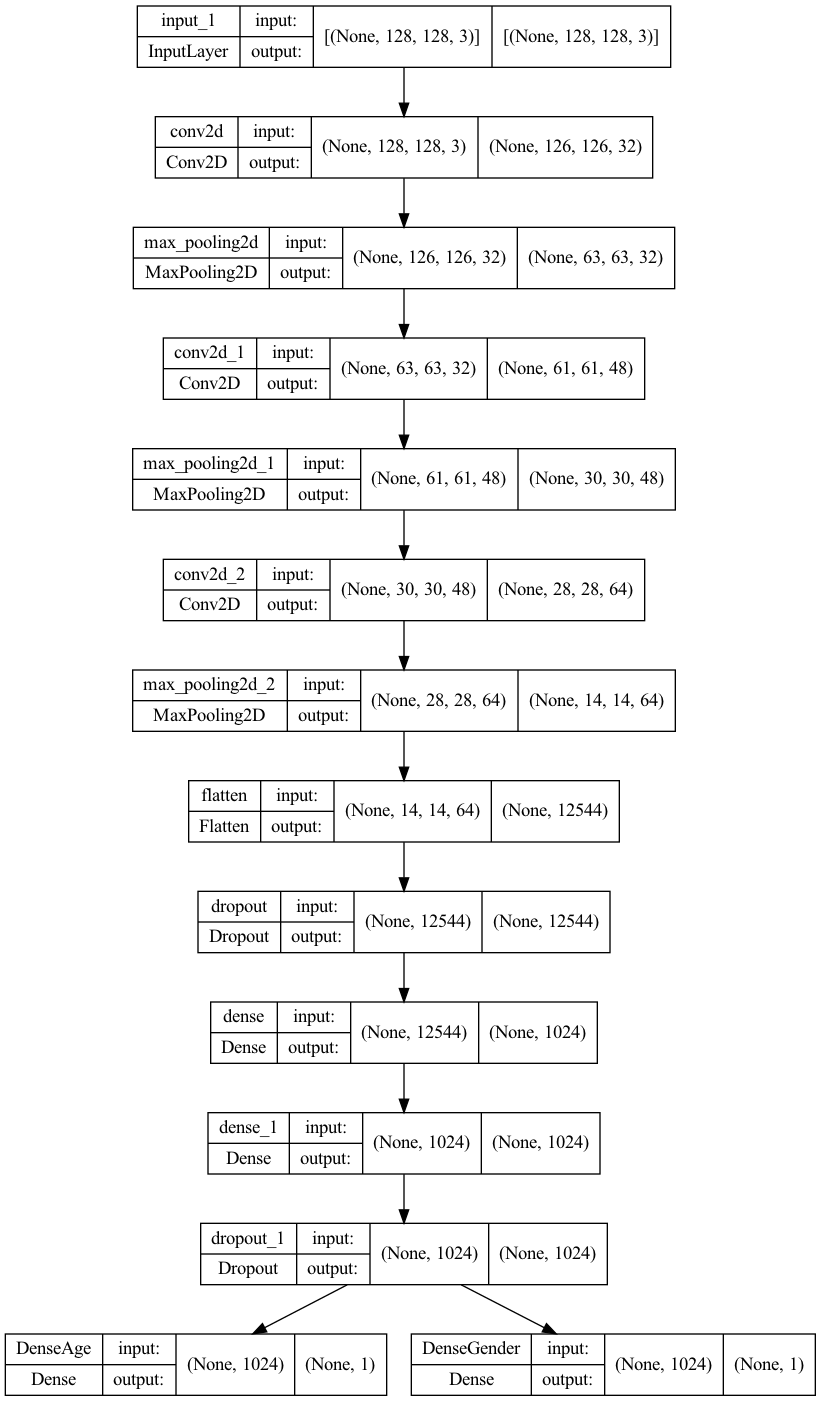

In [9]:
input = keras.Input(shape=INPUT_SHAPE)

x = layers.Conv2D(32, (3, 3))(input)
x = layers.MaxPooling2D()(x)

x = layers.Conv2D(48, (3, 3))(x)
x = layers.MaxPooling2D()(x)

x = layers.Conv2D(64, (3, 3))(x)
x = layers.MaxPooling2D()(x)


x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1024, activation="relu")(x)
x = layers.Dense(1024, activation="relu")(x)
x = layers.Dropout(0.5)(x)

out_age = layers.Dense(1, activation="relu", name="DenseAge")(x) # Using ReLU activation to skip negative values, as the age will never be negative
out_gender = layers.Dense(1, activation="sigmoid", name="DenseGender")(x) # Using sigmoid to limit 0 <= x <= 1
modelA = keras.models.Model(inputs = input, outputs = [out_age, out_gender])

modelA.summary()
from tensorflow.keras.utils import plot_model
plot_model(modelA, show_shapes=True)

## STEP3A: Compile and train your model
Compile and train your model here. 
Save your model by `modelA.save(your_model_folder+"age_gender_A.h5")` after training. 

**DON'T use any other name for your model file.** This is because my test code relies on this particular model name. Any other file name will cause problem in the testing stage.

**Save the model with `save()` instead of `save_weights()`.** This is because I will load the model by 

`modelA = load_model(model_folder+"age_gender_A.h5")`. 


In [10]:
modelA.compile(
    loss = {
        "DenseAge": 'mean_absolute_error',
        "DenseGender": 'binary_crossentropy'
    },

    metrics = {
        "DenseAge": 'mean_absolute_error',
        "DenseGender": 'binary_accuracy'
    },

    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
)

STEP_SIZE_TRAIN=data_generator_from_df.n//data_generator_from_df.batch_size
STEP_SIZE_VALID=val_data_generator_from_df.n//val_data_generator_from_df.batch_size

historyA = modelA.fit(
    x = custom_generator(data_generator_from_df),
    steps_per_epoch = STEP_SIZE_TRAIN,
    validation_steps = STEP_SIZE_VALID,
    validation_data=custom_generator(val_data_generator_from_df),
    epochs = EPOCHS,
    callbacks=[])

modelA.save(MODEL_FOLDER+"age_gender_A.h5")

Epoch 1/150


2022-03-21 18:55:27.458202: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-21 18:55:27.884858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - ETA: 0s - loss: 34.2349 - DenseAge_loss: 27.7907 - DenseGender_loss: 6.4442 - DenseAge_mean_absolute_error: 27.7907 - DenseGender_binary_accuracy: 0.5086

2022-03-21 18:55:35.059037: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 8s 250ms/step - loss: 34.2349 - DenseAge_loss: 27.7907 - DenseGender_loss: 6.4442 - DenseAge_mean_absolute_error: 27.7907 - DenseGender_binary_accuracy: 0.5086 - val_loss: 19.5864 - val_DenseAge_loss: 18.1277 - val_DenseGender_loss: 1.4587 - val_DenseAge_mean_absolute_error: 18.1277 - val_DenseGender_binary_accuracy: 0.4644
Epoch 2/150
29/29 [==============================] - 7s 254ms/step - loss: 16.9579 - DenseAge_loss: 16.0783 - DenseGender_loss: 0.8797 - DenseAge_mean_absolute_error: 16.0783 - DenseGender_binary_accuracy: 0.5149 - val_loss: 15.9287 - val_DenseAge_loss: 15.2365 - val_DenseGender_loss: 0.6922 - val_DenseAge_mean_absolute_error: 15.2365 - val_DenseGender_binary_accuracy: 0.5365
Epoch 3/150
29/29 [==============================] - 7s 232ms/step - loss: 16.0923 - DenseAge_loss: 15.3148 - DenseGender_loss: 0.7775 - DenseAge_mean_absolute_error: 15.3148 - DenseGender_binary_accuracy: 0.5146 - val_loss: 15.4752 - val_DenseAge_loss: 

## STEP4A: Draw the learning curves
Draw four figures as follows
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set


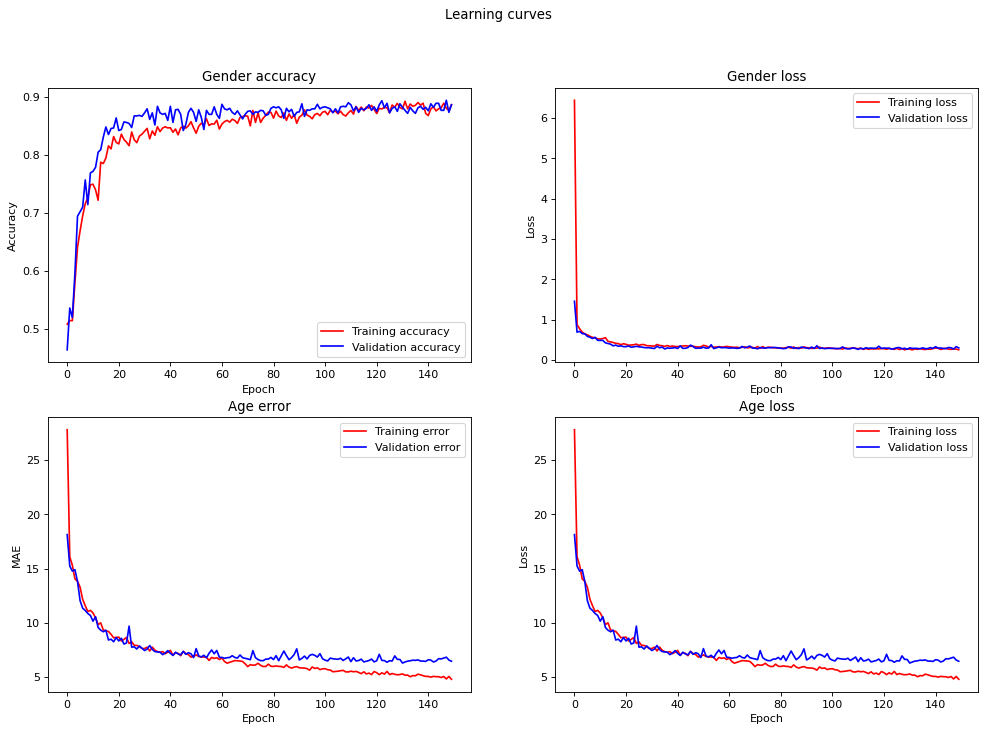

In [11]:
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['figure.dpi'] = 80

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.suptitle('Learning curves')

# Plot Gender
gender_acc = historyA.history['DenseGender_binary_accuracy']
gender_val_acc = historyA.history['val_DenseGender_binary_accuracy']
gender_loss = historyA.history['DenseGender_loss']
gender_val_loss = historyA.history['val_DenseGender_loss']

epochs = range(len(gender_acc))

ax1.plot(epochs, gender_acc, 'r', label='Training accuracy')
ax1.plot(epochs, gender_val_acc, 'b', label='Validation accuracy')
ax1.set_title('Gender accuracy')
ax1.legend(loc=0)
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')

ax2.plot(epochs, gender_loss, 'r', label='Training loss')
ax2.plot(epochs, gender_val_loss, 'b', label='Validation loss')
ax2.set_title('Gender loss')
ax2.legend(loc=0)
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')

# Plot Age
age_mae = historyA.history['DenseAge_mean_absolute_error']
age_val_mae = historyA.history['val_DenseAge_mean_absolute_error']
age_loss = historyA.history['DenseAge_loss']
age_val_loss = historyA.history['val_DenseAge_loss']

ax3.plot(epochs, age_mae, 'r', label='Training error')
ax3.plot(epochs, age_val_mae, 'b', label='Validation error')
ax3.set_title('Age error')
ax3.legend(loc=0)
ax3.set_ylabel('MAE')
ax3.set_xlabel('Epoch')

ax4.plot(epochs, age_loss, 'r', label='Training loss')
ax4.plot(epochs, age_val_loss, 'b', label='Validation loss')
ax4.set_title('Age loss')
ax4.legend(loc=0)
ax4.set_ylabel('Loss')
ax4.set_xlabel('Epoch')

plt.show()

## STEP2B: Build a CNN network based on a pre-trained model 
Choose one existing CNN architecture pre-trained on ImageNet, and fine-tune on this dataset.

The same as required in Model A, **don’t resize the input image size**. **The output layer for the gender branch is set to have only 1 unit**. 

In the end of the cell, use `modelB.summary()` to output the model architecture. You may also use `plot_model()` to visualize its architecture.


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 128, 128, 3)  0           ['input_2[0][0]']                
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 128, 128, 3)  0           ['tf.math.truediv[0][0]']        
                                                                                                  
 mobilenetv2_1.00_128 (Function  (None, 1000)        3538984     ['tf.math.subtract[0][0]'] 

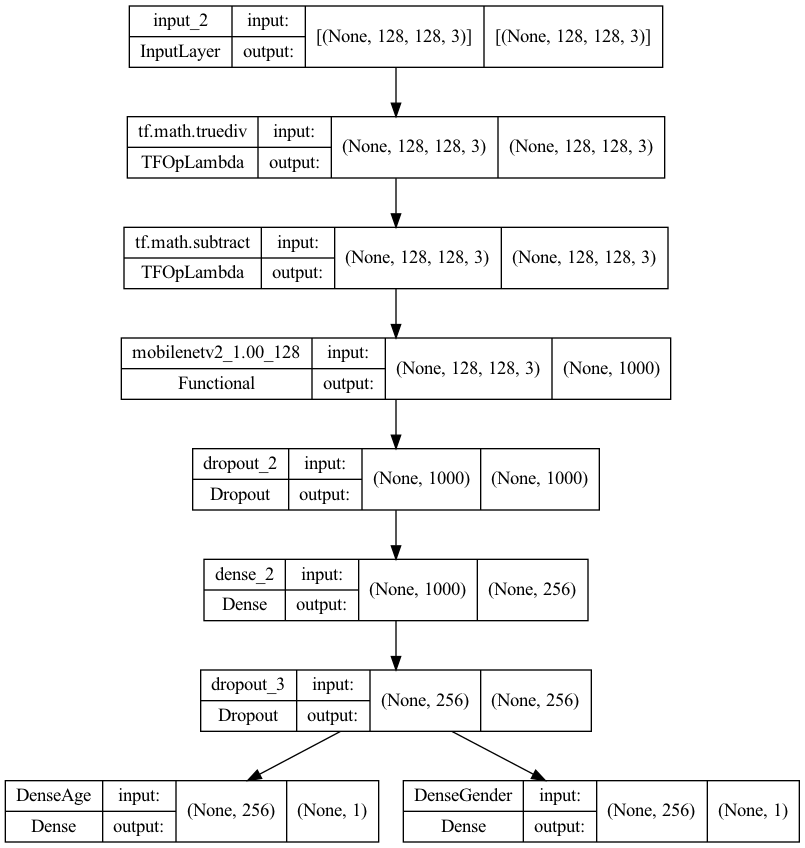

In [12]:
import tensorflow_hub as hub

input_layer = keras.Input(shape=INPUT_SHAPE)
x = tf.keras.applications.mobilenet_v2.preprocess_input(input_layer)
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,
                                               input_shape=INPUT_SHAPE,
                                               weights="imagenet",
                                               classifier_activation=None)
pretrained_model.trainable = True

x = pretrained_model(x, training=True)
x = tf.keras.layers.Dropout(rate=0.2)(x)
x = tf.keras.layers.Dense(256, 
                          activation="relu",
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
x = tf.keras.layers.Dropout(rate=0.5)(x)

out_age = layers.Dense(1,
                       activation="relu",
                       kernel_regularizer=tf.keras.regularizers.l2(0.0001),
                       name="DenseAge")(x)

out_gender = layers.Dense(1,
                          activation="sigmoid",
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001),
                          name="DenseGender")(x)

modelB = keras.models.Model(inputs=input_layer, outputs=[out_age, out_gender])

modelB.summary()
from tensorflow.keras.utils import plot_model
plot_model(modelB, show_shapes=True)


## STEP3B: Compile and train your model
Compile and train your model here. 
Save your model to `age_gender_B.h5` after training. 

**DON'T use any other name for your model file.** This is because my test code relies on this particular model name. Any other file name will cause problem in the testing stage.

**Also, save the model with `save()` instead of `save_weights()`.** 


In [13]:
modelB.compile(
    loss = {
        "DenseAge": 'mean_absolute_error',
        "DenseGender": 'binary_crossentropy'
    },

    metrics = {
        "DenseAge": 'mean_absolute_error',
        "DenseGender": 'binary_accuracy'
    },

    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
)

STEP_SIZE_TRAIN=data_generator_from_df.n//data_generator_from_df.batch_size
STEP_SIZE_VALID=val_data_generator_from_df.n//val_data_generator_from_df.batch_size

historyB = modelB.fit(
    x = custom_generator(data_generator_from_df),
    steps_per_epoch = STEP_SIZE_TRAIN,
    validation_steps = STEP_SIZE_VALID,
    validation_data=custom_generator(val_data_generator_from_df),
    epochs=50,
    callbacks=[])

modelB.save(MODEL_FOLDER+"age_gender_B.h5")

Epoch 1/50


2022-03-21 19:11:32.077891: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - ETA: 0s - loss: 19.5400 - DenseAge_loss: 15.7916 - DenseGender_loss: 3.7057 - DenseAge_mean_absolute_error: 15.7916 - DenseGender_binary_accuracy: 0.5563

2022-03-21 19:11:41.961758: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 13s 325ms/step - loss: 19.5400 - DenseAge_loss: 15.7916 - DenseGender_loss: 3.7057 - DenseAge_mean_absolute_error: 15.7916 - DenseGender_binary_accuracy: 0.5563 - val_loss: 13.2283 - val_DenseAge_loss: 12.1275 - val_DenseGender_loss: 1.0570 - val_DenseAge_mean_absolute_error: 12.1275 - val_DenseGender_binary_accuracy: 0.6398
Epoch 2/50
29/29 [==============================] - 8s 286ms/step - loss: 10.2281 - DenseAge_loss: 9.3690 - DenseGender_loss: 0.8149 - DenseAge_mean_absolute_error: 9.3690 - DenseGender_binary_accuracy: 0.6355 - val_loss: 9.4384 - val_DenseAge_loss: 8.8416 - val_DenseGender_loss: 0.5526 - val_DenseAge_mean_absolute_error: 8.8416 - val_DenseGender_binary_accuracy: 0.7127
Epoch 3/50
29/29 [==============================] - 9s 293ms/step - loss: 9.3942 - DenseAge_loss: 8.6355 - DenseGender_loss: 0.7147 - DenseAge_mean_absolute_error: 8.6355 - DenseGender_binary_accuracy: 0.6684 - val_loss: 8.2230 - val_DenseAge_loss: 7.6338 - v

## STEP4B: Draw the learning curve
Draw four figures as follows
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set

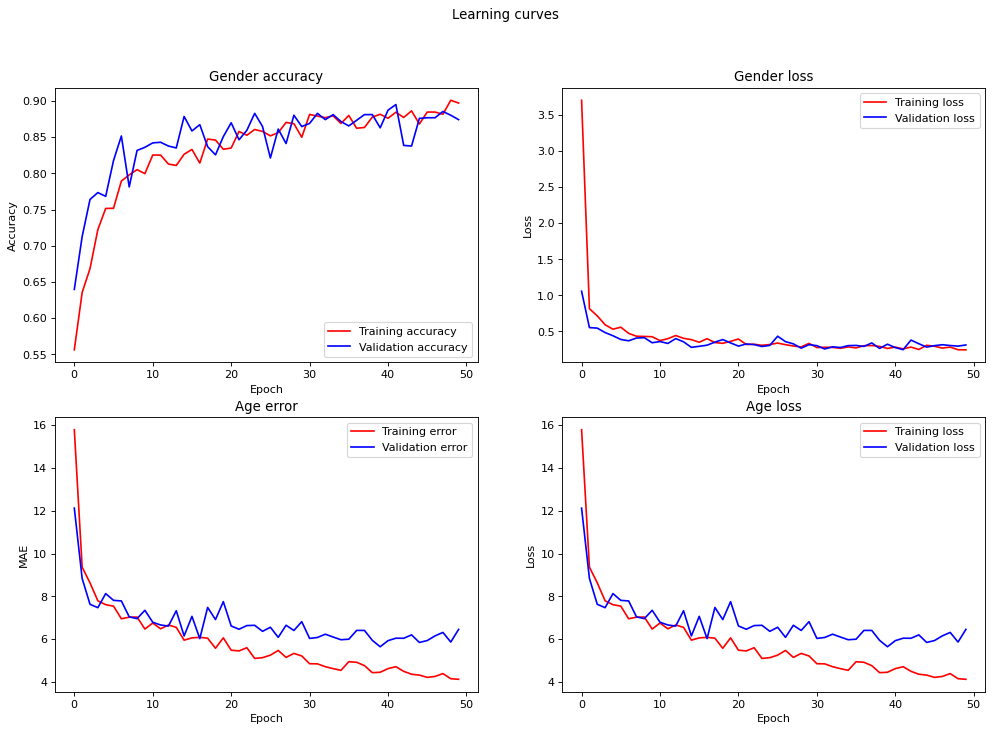

In [14]:
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['figure.dpi'] = 80

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.suptitle('Learning curves')

# Plot Gender
gender_acc = historyB.history['DenseGender_binary_accuracy']
gender_val_acc = historyB.history['val_DenseGender_binary_accuracy']
gender_loss = historyB.history['DenseGender_loss']
gender_val_loss = historyB.history['val_DenseGender_loss']

epochs = range(len(gender_acc))

ax1.plot(epochs, gender_acc, 'r', label='Training accuracy')
ax1.plot(epochs, gender_val_acc, 'b', label='Validation accuracy')
ax1.set_title('Gender accuracy')
ax1.legend(loc=0)
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')

ax2.plot(epochs, gender_loss, 'r', label='Training loss')
ax2.plot(epochs, gender_val_loss, 'b', label='Validation loss')
ax2.set_title('Gender loss')
ax2.legend(loc=0)
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')

# Plot Age
age_mae = historyB.history['DenseAge_mean_absolute_error']
age_val_mae = historyB.history['val_DenseAge_mean_absolute_error']
age_loss = historyB.history['DenseAge_loss']
age_val_loss = historyB.history['val_DenseAge_loss']

ax3.plot(epochs, age_mae, 'r', label='Training error')
ax3.plot(epochs, age_val_mae, 'b', label='Validation error')
ax3.set_title('Age error')
ax3.legend(loc=0)
ax3.set_ylabel('MAE')
ax3.set_xlabel('Epoch')

ax4.plot(epochs, age_loss, 'r', label='Training loss')
ax4.plot(epochs, age_val_loss, 'b', label='Validation loss')
ax4.set_title('Age loss')
ax4.legend(loc=0)
ax4.set_ylabel('Loss')
ax4.set_xlabel('Epoch')

plt.show()

## STEP5: Evaluate the model on the test set
I will add my test code here to test the two models you trained. The test set will not be available before your submission. 

The metrics for measuring the performance on the test set are:
- age estimation: MAE (Mean Absolute Error)
- gender classification: accuracy


In [ ]:
#
# Don't add code in this cell when submitting this file
#